# IMPORTS

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import glob

import PIL
import torchvision
import torch

# Load dataset

In [ ]:
trans = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.PILToTensor()
])

data = torchvision.datasets.ImageFolder(
    'data',
    transform=trans
    )

# Conv2d

In [73]:
def conv2d(
        data, 
        kernel, 
        stride=1, 
        padding=((1, 1), (1, 1)), 
        padding_item=0
    ):
    """
    data - Входной массив\n
    kernel - Ядро свертки\n
    stride - Шаг свертки\n
    padding - Размеры увелечения\n
    padding_item - Элемент вставки\n
    """
    #увеличение изображения 
    padding_data = np.pad(data, padding, mode='constant', constant_values=padding_item)

    #размер ядра свертки
    kernel_height, kernel_width = kernel.shape

    #размеры выходной матрицы
    grad_height, grad_width = (padding_data.shape - np.array((kernel_height, kernel_width)) + np.array((1, 1)))//stride
    grad = np.zeros((grad_height, grad_width), dtype=np.float64)

    #свертка
    for i in range(grad_height):
        for j in range(grad_width):
            grad[i, j] = np.sum(kernel * padding_data[i*stride:i*stride+kernel_height, j*stride:j*stride+kernel_width])
    
    return grad

# Matrix filter

In [138]:
matrix = np.array([
    [1, 1, 1, 1, 1, 1, 1],
    [1, -1, -1, -1, -1, -1, 1],
    [1, -1, 2, -4.5, 2, -1, 1],
    [1, -1, -4.5, 2, -4.5, -1, 1],
    [1, -1, 2, -4.5, 2, -1, 1],
    [1, -1, -1, -1, -1, -1, 1],
    [1, 1, 1, 1, 1, 1, 1],
])

C:\Users\Filic\AppData\Local\Temp\ipykernel_10576\3988443895.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


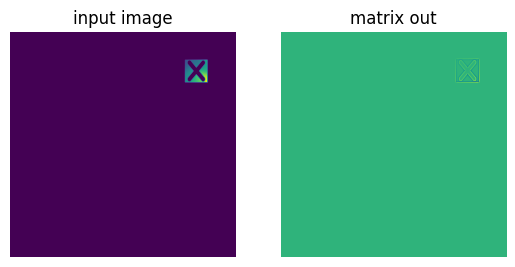

In [ ]:
id = np.random.randint(0, len(data))
data_inp = data[id][0][0]
conv_data = conv2d(data_inp, matrix)

fig, ax = plt.subplots(ncols=2)
ax[0].set_title('input image')
ax[0].axis('off')
ax[0].imshow(data_inp)

ax[1].set_title('matrix out')
ax[1].axis('off')
ax[1].imshow(conv_data)


fig.show()

# Sobel filter 

In [83]:
def sobel_filter(image):
    if type(image) == torch.Tensor():
        image = image.numpy()

    #ядра собеля
    sobel_x = np.array(
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ]
    )
    sobel_y = np.array(
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ]
    )

    #свертка 
    grad_x = conv2d(image, sobel_x)
    grad_y = conv2d(image, sobel_y)

    return grad_x, grad_y

### Test sobel

C:\Users\Filic\AppData\Local\Temp\ipykernel_10576\4153628975.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:298.)
  if type(image) == torch.Tensor():
C:\Users\Filic\AppData\Local\Temp\ipykernel_10576\1398594666.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


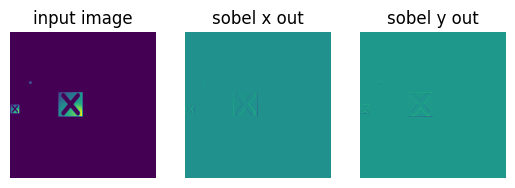

In [110]:
id = np.random.randint(0, len(data))
data_inp = data[id][0][0]
x, y = sobel_filter(data_inp)

fig, ax = plt.subplots(ncols=3)
ax[0].set_title('input image')
ax[0].axis('off')
ax[0].imshow(data_inp)

ax[1].set_title('sobel x out')
ax[1].axis('off')
ax[1].imshow(x)

ax[2].set_title('sobel y out')
ax[2].axis('off')
ax[2].imshow(y)

fig.show()

# Polar sobel

In [112]:
def compute_gradient_magnitude(sobel_x, sobel_y):
    comp_sobel = np.sqrt(pow(sobel_x, 2)+pow(sobel_y, 2))
    return comp_sobel

def compute_gradient_direction(sobel_x, sobel_y):
    tan_sobel = np.arctan2(sobel_y, sobel_x)
    return tan_sobel

### Test polar sobel

C:\Users\Filic\AppData\Local\Temp\ipykernel_10576\4153628975.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:298.)
  if type(image) == torch.Tensor():
C:\Users\Filic\AppData\Local\Temp\ipykernel_10576\3314298111.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


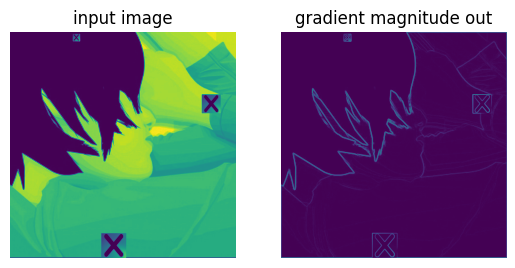

In [116]:
id = np.random.randint(0, len(data))
data_inp = data[id][0][0]
x, y = sobel_filter(data_inp)
magnitude = compute_gradient_magnitude(x, y)

fig, ax = plt.subplots(ncols=2)
ax[0].set_title('input image')
ax[0].axis('off')
ax[0].imshow(data_inp)

ax[1].set_title('gradient magnitude out')
ax[1].axis('off')
ax[1].imshow(magnitude)

fig.show()

# Detect

In [50]:
def detect_squares(image_path):
    #Загрузка изображения
    img = cv2.imread(image_path)

    #Конвертация в чб
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #размытие против шумов
    img = cv2.GaussianBlur(img, (5, 5), 0)

    #выделяем когтуры Бинаризация с адаптивным порогом
    img = cv2.adaptiveThreshold(img, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 11, 2)

    
    #улучшение контуров
    kernel = np.ones((3,3), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    #поиск контуров
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    squares = []
    for contour in contours:
        #замеряем длину контура
        perimeter = cv2.arcLength(contour, True)
        #делаем более линейным
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
        
        # проверка на квадрат
        if len(approx) == 4:
            # Вычисляем параметры для проверки 
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            
            #соотношения сторон
            if 0.7 <= aspect_ratio <= 1.3:
                # Вычисляем центр квадрата
                M = cv2.moments(approx)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                else:
                    cX, cY = x + w//2, y + h//2
                squares.append([(cX, cY), approx])    
    return squares

### test

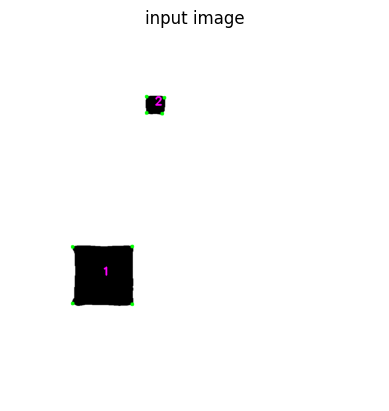

In [71]:
patch = 'mask/341.png'
square = detect_squares(patch)
img = cv2.imread(patch)
out_img = img.copy()

for ind, sqr in enumerate(square):
    cv2.drawContours(out_img, sqr[1], -1, (0, 255, 0), 10)
    cv2.putText(out_img, f"{ind+1}", sqr[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 3)

plt.title('input image')
plt.axis('off')
plt.imshow(out_img)

plt.show()

# Output

In [66]:
log = {
    'Fieds':[],
    'name': list(map(lambda item: item.split('\\')[1], glob.glob('data/image/*'))),
    'numOfObj':[],
    'dots':[]
}
for indx, filename in enumerate(glob.glob('mask/*')):
    log['Fieds'].append(indx+1)
    square = detect_squares(filename)
    log['numOfObj'].append(len(square))
    point = '['
    for item in square:
        if point != '[':
            point += '; '
        point += f'{item[0][0]}, {item[0][1]}'
    point += ']'
    log['dots'].append(point)
    

In [52]:
import pandas as pd

In [67]:
submit = pd.DataFrame(log)
submit

,Fieds,name,numOfObj,dots
0,1,00000001.png,1,"[768, 718]"
1,2,00000002.png,3,"[158, 924; 905, 621; 785, 515]"
2,3,00000003.png,1,"[917, 548]"
3,4,00000004.png,2,"[121, 953; 439, 368]"
4,5,00000005.png,3,"[671, 647; 346, 601; 355, 153]"
...,...,...,...,...
395,396,00000396.png,1,"[184, 314]"
396,397,00000397.png,1,"[794, 146]"
397,398,00000398.png,3,"[81, 649; 682, 243; 603, 84]"
398,399,00000399.png,1,"[822, 175]"


In [68]:
submit.to_csv('submit.csv', index=False)